### Currently, this notebook is used for:
    - loading the sfMixLGN experiment data in python format
    - plotting responses

### Set up

In [362]:
import os
import numpy as np
import matplotlib
matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import helper_fcns
import autoreload

import sys # so that we can import model_responses (in different folder)
import model_responses

% matplotlib inline 

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/Analysis/Functions/paul_plt_cluster.mplstyle');

# at CNS
# dataPath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/recordings/';
# savePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/analysis/';
# personal mac
dataPath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/structures/';
save_loc = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/LGN/analysis/figures/';

conDig = 3; # round contrast to the 3rd digit
fullWaveform = 0;

which_cell = 31; # index into the dataList

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();

if fullWaveform:
    waveStr = '_fullWave'
else:
    waveStr = '';
    
cellStruct = np.load(dataPath + dataList['unitName'][which_cell] + '_sfm' + waveStr + '.npy', encoding='latin1').item();

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [363]:
data = cellStruct['sfm']['exp']['trial'];

A quick look at spikes versus f1 power

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


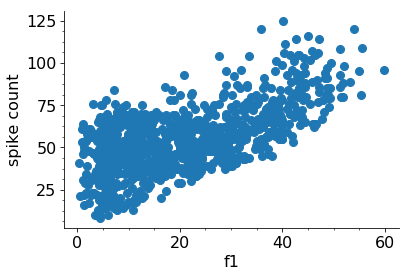

In [3]:
plt.plot(np.abs(data['f1']), np.abs(data['spikeCount']), 'o');
plt.xlabel('f1');
plt.ylabel('spike count');

### Organize data
#### determine contrasts, center spatial frequency, dispersions

In [8]:
data = cellStruct['sfm']['exp']['trial'];

resp, stimVals, val_con_by_disp, validByStimVal, mdRsp = helper_fcns.tabulate_responses(cellStruct);

all_disps = stimVals[0];
all_cons = stimVals[1];
all_sfs = stimVals[2];

nCons = len(all_cons);
nSfs = len(all_sfs);
nDisps = len(all_disps);

#### Unpack responses

In [9]:
# respMean = resp[0];
# respStd = resp[1];
predMean = resp[2];
predStd = resp[3];
respMean = resp[4];
respStd = resp[5];

#### Load descriptive model fits

In [ ]:
descrFits = np.load(dataPath + 'descrFits.npy', encoding = 'latin1').item();
descrFits = descrFits[which_cell]['params']; # just get this cell

### Plots

#### Plots by dispersion

In [ ]:
fDisp = []; dispAx = [];

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);    

for d in range(nDisps):
    
    v_cons = val_con_by_disp[d];
    n_v_cons = len(v_cons);
    
    fCurr, dispCurr = plt.subplots(n_v_cons, 1, figsize=(40, n_v_cons*10));
    fDisp.append(fCurr)
    dispAx.append(dispCurr);
    
    maxResp = np.max(np.max(respMean[d, ~np.isnan(respMean[d, :, :])]));
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = len(v_cons) - c - 1;
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                      respStd[d, v_sfs, v_cons[c]], fmt='o');
        # plot linear prediction
        dispAx[d][c_plt_ind].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x');
        
        # plot descriptive model fit
#         curr_mod_params = descrFits[d, v_cons[c], :];
        #dispAx[d][c_plt_ind].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))
        
        dispAx[d][c_plt_ind].set_xlim((min(all_sfs), max(all_sfs)));
        dispAx[d][c_plt_ind].set_ylim((0, 1.5*maxResp));
        
        dispAx[d][c_plt_ind].set_xscale('log');
#         dispAx[d][c].set_yscale('log');
        dispAx[d][c_plt_ind].set_xlabel('sf (c/deg)'); 
        dispAx[d][c_plt_ind].set_ylabel('resp (sps)');
        dispAx[d][c_plt_ind].set_title('D%d: contrast: %.3f' % (d+1, all_cons[v_cons[c]]));


saveName = "/cell_%d.pdf" % (which_cell+1)
full_save = os.path.dirname(str(save_loc + 'byDisp/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fDisp:
    pdfSv.savefig(f)
pdfSv.close()


#### Plot just sfMix contrasts

In [ ]:
# i.e. highest (up to) 4 contrasts for each dispersion

plot_descr = 0;

mixCons = 4;
maxResp = np.max(np.max(np.max(respMean[~np.isnan(respMean)])));

f, sfMixAx = plt.subplots(mixCons, nDisps, figsize=(40, 30));

sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

for d in range(nDisps):
    v_cons = np.array(val_con_by_disp[d]);
    n_v_cons = len(v_cons);
    v_cons = v_cons[np.arange(np.maximum(0, n_v_cons -mixCons), n_v_cons)]; # max(1, .) for when there are fewer contrasts than 4
    n_v_cons = len(v_cons);
    
    for c in reversed(range(n_v_cons)):
        c_plt_ind = n_v_cons - c - 1;
        sfMixAx[c_plt_ind, d].set_title('con:' + str(np.round(all_cons[v_cons[c]], 2)))
        v_sfs = ~np.isnan(respMean[d, :, v_cons[c]]);
        
        # plot data
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], respMean[d, v_sfs, v_cons[c]], 
                                       respStd[d, v_sfs, v_cons[c]], fmt='o');

        # plot linear prediction
        sfMixAx[c_plt_ind, d].errorbar(all_sfs[v_sfs], predMean[d, v_sfs, v_cons[c]], 
                                      predStd[d, v_sfs, v_cons[c]], fmt='x');
        
        # plot descriptive model fit
        if plot_descr:
            curr_mod_params = descrFits[d, v_cons[c], :];
        #sfMixAx[c_plt_ind, d].plot(sfs_plot, helper_fcns.flexible_Gauss(curr_mod_params, sfs_plot))

        sfMixAx[c_plt_ind, d].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        sfMixAx[c_plt_ind, d].set_ylim((0, 1.5*maxResp));
        sfMixAx[c_plt_ind, d].set_xscale('log');
        sfMixAx[c_plt_ind, d].set_xlabel('sf (c/deg)');
        sfMixAx[c_plt_ind, d].set_ylabel('resp (sps)');
        
saveName = "/cell_%d.pdf" % (which_cell+1)
full_save = os.path.dirname(str(save_loc + 'sfMixOnly/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

#### Plot contrast response functions

In [ ]:
crfAx = []; fCRF = [];

for d in range(nDisps):
    
    # which sfs have at least one contrast presentation?
    v_sfs = np.where(np.sum(~np.isnan(respMean[d, :, :]), axis = 1) > 0);
    n_v_sfs = len(v_sfs[0])
    fCurr, crfCurr = plt.subplots(1, n_v_sfs, figsize=(n_v_sfs*15, 20), sharex = True, sharey = True);
    fCRF.append(fCurr)
    crfAx.append(crfCurr);
    
    for sf in range(n_v_sfs):
        sf_ind = v_sfs[0][sf];
        v_cons = ~np.isnan(respMean[d, sf_ind, :]);
        n_cons = sum(v_cons);
        
        # 0.1 minimum to keep plot axis range OK...should find alternative
        crfAx[d][sf].errorbar(all_cons[v_cons], np.maximum(np.reshape([respMean[d, sf_ind, v_cons]], (n_cons, )), 0.1),
                            np.reshape([respStd[d, sf_ind, v_cons]], (n_cons, )), fmt='o');
        crfAx[d][sf].set_xscale('log');
        crfAx[d][sf].set_yscale('log');
        crfAx[d][sf].set_xlabel('contrast');
        crfAx[d][sf].set_ylabel('resp (sps)');
        crfAx[d][sf].set_title('D%d: sf: %.3f' % (d+1, all_sfs[sf_ind]));

saveName = "/cell_%d.pdf" % (which_cell+1)
full_save = os.path.dirname(str(save_loc + 'CRF/'));
if not os.path.exists(full_save):
    os.makedirs(full_save)
pdfSv = pltSave.PdfPages(full_save + saveName);
for f in fCRF:
    pdfSv.savefig(f)
pdfSv.close()

### Fourier analysis

In [489]:
autoreload.reload(helper_fcns);

Section for testing out Fourier analysis in python - create a PSTH from the spike times and take the Fourier transform to determine the response amplitude at a given frequency. We will looking specifically for responses at the stimulus temporal frequencies. 

First, find out which trials are valid (i.e. not blanks)

In [490]:
val_trials = np.where(~np.isnan(data['tf'][0]))[0];

Sort the data in terms of which trials have the largest f1 component

In [491]:
b = np.argsort(np.abs(data['f1'][val_trials]))

Now which of those indices correspond to dispersed gratings (just so it's easier to check)

In [492]:
np.where(data['num_comps'][val_trials][b] == 5)[0]

array([204, 320, 347, 376, 385, 388, 403, 410, 420, 444, 457, 458, 463,
       468, 474, 475, 476, 483, 484, 509, 510, 522, 525, 529, 533, 536,
       538, 542, 546, 548, 552, 554, 558, 562, 566, 569, 576, 581, 586,
       588, 598, 604, 606, 608, 609, 610, 615, 628, 630, 631, 632, 637,
       644, 647, 652, 656, 660, 661, 665, 667, 671, 678, 679, 680, 685,
       688, 689, 690, 695, 701, 702, 705, 714, 718, 719, 721, 732, 744,
       754, 759, 765, 766, 767, 768, 773, 774, 776, 782, 788, 820])

Organize the temporal frequencies for each (valid) trial

In [520]:
sp = np.array(np.nan * np.zeros(900, ), dtype='O')

In [528]:
sp[5]

4

In [519]:
bbbb.dtype

dtype('float64')

In [493]:
bbbb = np.vstack((data['tf'][0], data['tf'][1], data['tf'][2], data['tf'][3], data['tf'][4]));
all_all_tfs = np.transpose(bbbb)[val_trials];
all_tfs = all_all_tfs.astype(int)
atz = [[x[0]] if x[0] == x[1] else x for x in all_tfs];

Now do the analysis: create psth, fourier transform

In [495]:
binWidth = 1e-3; # in s
whichInd = 890; # which index into "b"
stimDur = 1; # in s

In [496]:
psth_blank, _ = helper_fcns.make_psth(binWidth, stimDur, allSpikes);
spect_blank, _ = helper_fcns.spike_fft(psth_blank);

In [497]:
psth, _ = helper_fcns.make_psth(binWidth, stimDur, allSpikes[val_trials]);
psth_abbr = [x[50:] for x in psth];

In [511]:
rel_power[b[820]]

array([34.12434186, 14.45664844,  5.62609282,  4.48807985,  2.01222224])

In [498]:
spect, rel_power = helper_fcns.spike_fft(psth, atz);
spect_abbr, rel_power_abbr = helper_fcns.spike_fft(psth_abbr, all_tfs);

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [417]:
allSpikes = data['spikeTimes'];
valInd = b[whichInd];
trial = val_trials[valInd];

times = np.linspace(0, stimDur, 1+stimDur/binWidth);
c1 = []; c2 = []; c3 = []; c4 = []; c5 = [];

sfs_curr = [x[trial] for x in data['sf']];
cons_curr = [x[trial] for x in data['con']];

tfs_curr = all_tfs[valInd]; # index the below separately, since we've already "killed" invalid trials from this 
psth_curr = psth[valInd];
spect_curr = spect[valInd];
rel_power_curr = rel_power[valInd];

psth_abbr_curr = psth_abbr[valInd]; 
spect_abbr_curr = spect_abbr[valInd];
rp_abbr_curr = rel_power_abbr[valInd];

nyquist = int(len(spectrum)/2);
crop_fft = int(np.minimum(nyquist, 3*np.max(tfsCurr)));

/Users/paulgerald/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


/Users/paulgerald/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


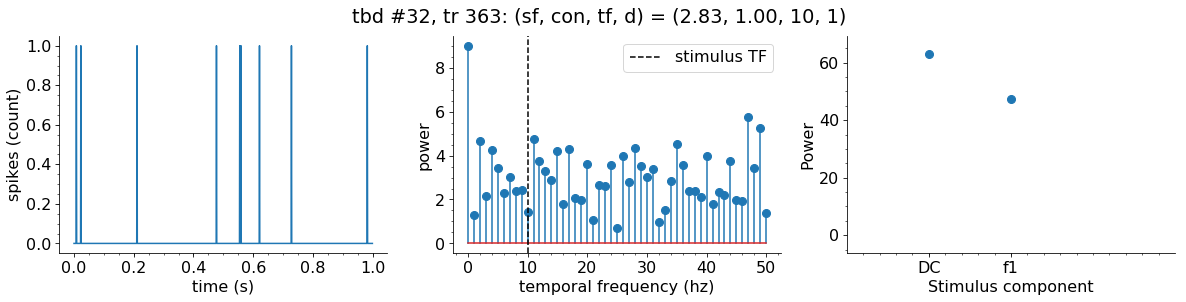

In [448]:
f, ax = plt.subplots(1, 3, figsize=(20, 4))

plt.subplot(1, 3, 1);
plt.plot(times[0:-1], psth_blank);
# plt.plot(times[0:-1], psth_curr);
# plt.plot(times[0:-1], psth);
plt.xlabel('time (s)');
plt.ylabel('spikes (count)')

plt.subplot(1, 3, 2);
plt.stem(np.abs(spect_blank[0:crop_fft]), alpha=0.4);
# plt.stem(np.abs(spect_curr[0:crop_fft]), alpha=0.4);
# plt.stem(np.abs(spect_abbr_curr[0:crop_fft]), alpha=0.4, color='r');
c1 = plt.axvline(tfs_curr[0], ls='dashed', color='k');
if data['num_comps'][trial] > 1:
    c2 = plt.axvline(tfs_curr[1], ls='dashed', color='r')
    c3 = plt.axvline(tfs_curr[2], ls='dashed', color='g')
    c4 = plt.axvline(tfs_curr[3], ls='dashed', color='b')
    c5 = plt.axvline(tfs_curr[4], ls='dashed', color='c')
    
plt.xlabel('temporal frequency (hz)');
plt.ylabel('power')
if not c2:
    plt.legend([c1], ['stimulus TF'])
else:
    plt.legend((c1, c2, c3, c4, c5), ('tf1', 'tf2', 'tf3', 'tf4', 'tf5'));

plt.subplot(1, 3, 3);
if c2:
    full = plt.plot(np.arange(6), np.insert(rel_power_curr, 0, spect_curr[0]), 'o'); # to plot the DC
#     abbr = plt.plot(np.arange(6), np.insert(rp_abbr_curr, 0, spect_abbr_curr[0]), 'o'); # to plot the DC
    plt.xticks(np.arange(6), ('DC', 'tf1', 'tf2', 'tf3', 'tf4', 'tf5'))
    plt.xlim([-1, 7])
else:
    full = plt.plot(np.arange(2), [spect_curr[0], rel_power_curr[0]], 'o');
#     abbr = plt.plot(np.arange(2), [spect_abbr_curr[0], rp_abbr_curr[0]], 'o');
    plt.xticks(np.arange(2), ('DC', 'f1'))
    plt.xlim([-1, 3])
    
plt.xlabel('Stimulus component');
plt.ylabel('Power');
plt.ylim([-0.1*spect_curr[0], 1.1*spect_curr[0]]);
# plt.legend((full[0], abbr[0]), ('full', 'abbreviated'));

plt.suptitle('%s #%d, tr %d: (sf, con, tf, d) = (%.2f, %.2f, %d, %d)' % (dataList['unitType'][which_cell], which_cell+1, trial+1,
                                                                    sfs_curr[0], np.sum(cons_curr), tfs_curr[0], data['num_comps'][trial]));